<img src="../Pierian-Data-Logo.PNG">
<br>
<strong><center>Copyright 2019. Created by Jose Marcial Portilla.</center></strong>

# RNN on a Time Series
For these examples we're using data from the Federal Reserve Economic Database (FRED) concerning Sales of Beer, Wine, and Distilled Alcoholic Beverages in millions of dollars from January 1992 to January 2019 (325 records).

Data source: https://fred.stlouisfed.org/series/S4248SM144NCEN

## Perform standard imports

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# This relates to plotting datetime values with matplotlib:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Load the dataset
We'll take advantage of pandas' built-in <a href='https://pandas.pydata.org/pandas-docs/stable/timeseries.html'>DatetimeIndex</a> by passing <tt>parse_dates=True</tt>

In [2]:
df = pd.read_csv('../Data/TimeSeriesData/Alcohol_Sales.csv',index_col=0,parse_dates=True)
len(df)

325

In [3]:
# Always a good idea with time series data:
df.dropna(inplace=True)
len(df)

325

In [4]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [5]:
df.tail()

,S4248SM144NCEN
DATE,
2018-09-01,12396
2018-10-01,13914
2018-11-01,14174
2018-12-01,15504
2019-01-01,10718


## Plotting time series data
We can add titles, axis labels, and other features to the plot.<br>
We're going to tighten the x-axis to fit the width of the actual data with <tt>plt.autoscale(axis='x',tight=True)</tt>.<br>
Alternatively you could set your own limits with <tt>plt.xlim(pd.Timestamp('1992-01-01'), pd.Timestamp('2019-01-01'))</tt> or some other values.

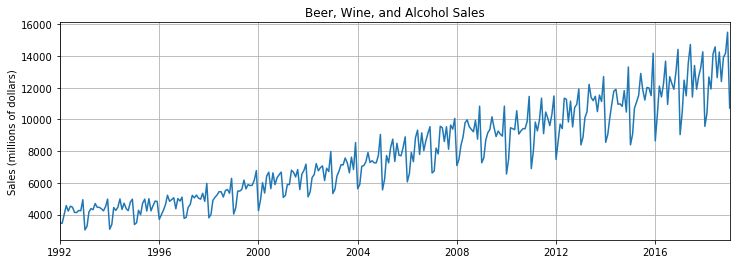

In [6]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.show()

## Prepare the data
In the next steps we'll divide the data into train/test sets, then normalize the training values so that they fall between -1 and 1 (to improve training). We'll train the model, then predict into a period that matches the test set. Finally, we'll forecast into an unknown future.

In [7]:
# Extract values from the source .csv file
y = df['S4248SM144NCEN'].values.astype(float)

# Define a test size
test_size = 12

# Create train and test sets
train_set = y[:-test_size]
test_set = y[-test_size:]

In [8]:
test_set

array([10415., 12683., 11919., 14138., 14583., 12640., 14257., 12396.,
       13914., 14174., 15504., 10718.])

It's worth noting that in our previous exercise the train and test sets were tensors. Here they're numpy arrays. This is because one of the steps we're about to perform outputs an array, and we'd have to turn it into a tensor anyway.

## Normalize the data
The formula for normalizing data around zero is:<br>
### $X_{norm} = \frac{X - \mu} {\sigma}$
where $\mu$ is the population mean, and $\sigma$ is the population standard deviation.<br>
Recall that back in the CNN section we transformed image files using <a href='https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize'><tt><strong>torchvision.transforms.Normalize(<em>mean, std</em>)</strong></tt></a>, both because it was built into DataLoader, and because our pretrained models expected specific normalization values.<br>

Ultimately we want to perform <a href='https://en.wikipedia.org/wiki/Feature_scaling'>min/max feature scaling</a> so that our values fall between -1 and 1, as this makes hyperparameters converge faster.<br>The formula for this would be:<br>
### $X^{\prime} = a + \frac{(X - X_{min}) (b - a)} {X_{max} - X_{min}}$
where $a={-1}$ and $b=1$<br>

We can use scikit-learn to do this, with <a href='https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html'><tt><strong>sklearn.preprocessing.MinMaxScaler()</strong></tt></a>

NOTE: We only want to normalize the training set to avoid data leakage. If we include the test set then the higher average values of the test set could become part of the signal in the training set. There's a good article on data leakage <a href='test_set = input_data(test_norm,window_size)'>here</a>.

After using transformed data to train the model and generate predictions, we'll inverse_transform the predicted values so that we can compare them to the actual test data.

In [9]:
from sklearn.preprocessing import MinMaxScaler

# Instantiate a scaler with a feature range from -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))

In [10]:
# Normalize the training set
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

In [11]:
train_norm.min()

-1.0

In [12]:
train_norm.max()

1.0

In [13]:
train_norm.mean()

-0.2041940178388313

In [14]:
type(train_norm)

numpy.ndarray

## Prepare data for LSTM
Here we'll create our list of (seq/label) tuples from the training set. Recall that an LSTM consumes a window of samples toward the first prediction, so the size of our training set will become ((325 - test_size) - window_size).

In [15]:
# Convert train_norm from an array to a tensor
train_norm = torch.FloatTensor(train_norm).view(-1)

# Define a window size
window_size = 12

# Define function to create seq/label tuples
def input_data(seq,ws):  # ws is the window size
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

# Apply the input_data function to train_norm
train_data = input_data(train_norm,window_size)
len(train_data)  # this should equal 325-12-12

301

In [16]:
# Display the first seq/label tuple in the train data
train_data[0]

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901, -0.7933, -0.6743]), tensor([-1.]))

## Define the model
This time we'll use an LSTM layer of size (1,100).

In [16]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]  # we only want the last value

## Instantiate the model, define loss and optimization functions

In [17]:
torch.manual_seed(101)
model = LSTMnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [18]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

   400
 40000
   400
   400
   100
     1
______
 41301


## Train the model

In [19]:
epochs = 100

import time
start_time = time.time()

for epoch in range(epochs):
    
    # extract the sequence & label from the training data
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.25314346
Epoch:  2 Loss: 0.37523893
Epoch:  3 Loss: 0.39012098
Epoch:  4 Loss: 0.34949699
Epoch:  5 Loss: 0.33077896
Epoch:  6 Loss: 0.33230731
Epoch:  7 Loss: 0.32667705
Epoch:  8 Loss: 0.32077038
Epoch:  9 Loss: 0.30651760
Epoch: 10 Loss: 0.29517007
Epoch: 11 Loss: 0.26913956
Epoch: 12 Loss: 0.25979379
Epoch: 13 Loss: 0.24600089
Epoch: 14 Loss: 0.22227961
Epoch: 15 Loss: 0.18593504
Epoch: 16 Loss: 0.18445803
Epoch: 17 Loss: 0.17432828
Epoch: 18 Loss: 0.25821912
Epoch: 19 Loss: 0.22419100
Epoch: 20 Loss: 0.23125543
Epoch: 21 Loss: 0.19775060
Epoch: 22 Loss: 0.19052812
Epoch: 23 Loss: 0.21531571
Epoch: 24 Loss: 0.16730183
Epoch: 25 Loss: 0.14663692
Epoch: 26 Loss: 0.12183882
Epoch: 27 Loss: 0.05807713
Epoch: 28 Loss: 0.00280405
Epoch: 29 Loss: 0.00588252
Epoch: 30 Loss: 0.03215095
Epoch: 31 Loss: 0.00154577
Epoch: 32 Loss: 0.04653292
Epoch: 33 Loss: 0.04473343
Epoch: 34 Loss: 0.02252420
Epoch: 35 Loss: 0.03957854
Epoch: 36 Loss: 0.00021776
Epoch: 37 Loss: 0.00147535
E

## Run predictions and compare to known test set

In [21]:
future = 12

# Add the last window of training values to the list of predictions
preds = train_norm[-window_size:].tolist()

# Set the model to evaluation mode
model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

In [22]:
# Display predicted values
preds[window_size:]    # equivalent to preds[-future:]

[0.28332826495170593,
 0.6684253215789795,
 0.45645177364349365,
 0.8633188009262085,
 1.1005345582962036,
 0.4227672815322876,
 0.8391242027282715,
 0.5979450941085815,
 0.6170685291290283,
 0.7916786074638367,
 0.917717456817627,
 0.15471792221069336]

## Invert the normalization
We want to compare our test predictions to the original data, so we need to undo the previous normalization step. Note that <tt>inverse_transform</tt> uses the most recently applied parameters; we can rescale based on the test data, but not on the previous training data.

In [23]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[10537.82868584],
       [12790.45391858],
       [11550.51464993],
       [13930.48332602],
       [15318.07689875],
       [11353.47721332],
       [13788.95702386],
       [12378.17982799],
       [12490.04236114],
       [13511.42401436],
       [14248.68826365],
       [ 9785.52248597]])

In [24]:
df['S4248SM144NCEN'][-12:]

DATE
2018-02-01    10415
2018-03-01    12683
2018-04-01    11919
2018-05-01    14138
2018-06-01    14583
2018-07-01    12640
2018-08-01    14257
2018-09-01    12396
2018-10-01    13914
2018-11-01    14174
2018-12-01    15504
2019-01-01    10718
Name: S4248SM144NCEN, dtype: int64

It looks like our predictions weren't that far off!
## Plot the results
Our original data contains a datetime index, but our predicted values do not. We can create a range of dates using NumPy that are spaced one month apart using <tt>dtype='datetime64[M]'</tt>, and then store them with day values to match our dataset with <tt>.astype('datetime64[D]')</tt>.

In [25]:
# Remember that the stop date has to be later than the last predicted value.
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]').astype('datetime64[D]')
x

array(['2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
       '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
       '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01'],
      dtype='datetime64[D]')

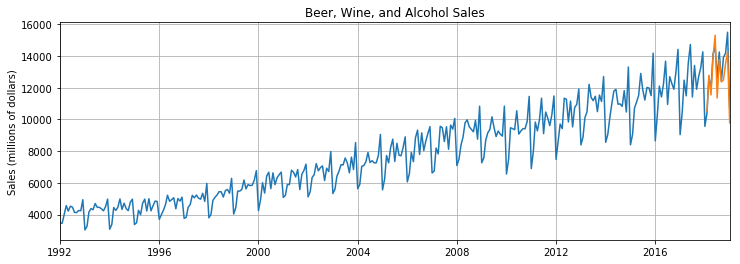

In [26]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions)
plt.show()

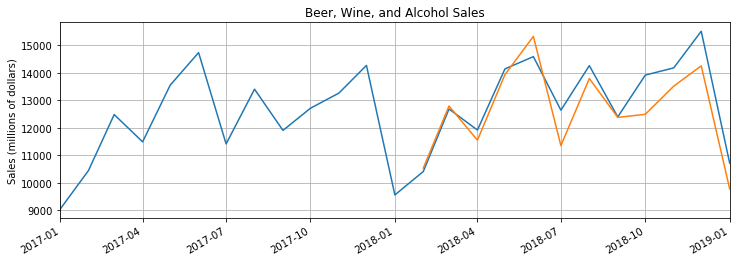

In [27]:
# Plot the end of the graph
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

# Select the end of the graph with slice notation:
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions)
plt.show()

For more information on x-axis date formatting in matplotlib, check out <a href='https://matplotlib.org/api/_as_gen/matplotlib.figure.Figure.html#matplotlib.figure.Figure.autofmt_xdate'><tt><strong>matplotlib.figure.Figure.autofmt_xdate</strong></tt></a> and <a href='https://matplotlib.org/api/dates_api.html#matplotlib.dates.DateFormatter'><tt><strong>matplotlib.dates.DateFormatter</strong></tt></a>

# Forecast into an unknown future
This time we'll continue training the model using the entire dataset, and predict 12 steps into the future.

In [28]:
epochs = 100

# set model to back to training mode
model.train()

# feature scale the entire dataset
y_norm = scaler.fit_transform(y.reshape(-1, 1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm,window_size)

import time
start_time = time.time()

for epoch in range(epochs):
    
    # train on the full set of sequences
    for seq, y_train in all_data:  
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.01678807
Epoch:  2 Loss: 0.02173188
Epoch:  3 Loss: 0.02237127
Epoch:  4 Loss: 0.01401217
Epoch:  5 Loss: 0.01228430
Epoch:  6 Loss: 0.01233562
Epoch:  7 Loss: 0.01248281
Epoch:  8 Loss: 0.01292917
Epoch:  9 Loss: 0.01160758
Epoch: 10 Loss: 0.01049056
Epoch: 11 Loss: 0.01137544
Epoch: 12 Loss: 0.01159553
Epoch: 13 Loss: 0.00894520
Epoch: 14 Loss: 0.00865178
Epoch: 15 Loss: 0.01039598
Epoch: 16 Loss: 0.00925289
Epoch: 17 Loss: 0.00988827
Epoch: 18 Loss: 0.00540351
Epoch: 19 Loss: 0.00490391
Epoch: 20 Loss: 0.00609499
Epoch: 21 Loss: 0.00695134
Epoch: 22 Loss: 0.00477669
Epoch: 23 Loss: 0.00621205
Epoch: 24 Loss: 0.00611163
Epoch: 25 Loss: 0.00730484
Epoch: 26 Loss: 0.00674757
Epoch: 27 Loss: 0.00193071
Epoch: 28 Loss: 0.00215150
Epoch: 29 Loss: 0.00394597
Epoch: 30 Loss: 0.00511921
Epoch: 31 Loss: 0.00666541
Epoch: 32 Loss: 0.00580890
Epoch: 33 Loss: 0.00511965
Epoch: 34 Loss: 0.00444843
Epoch: 35 Loss: 0.00124777
Epoch: 36 Loss: 0.00076138
Epoch: 37 Loss: 0.00266317
E

## Predict future values, plot the result

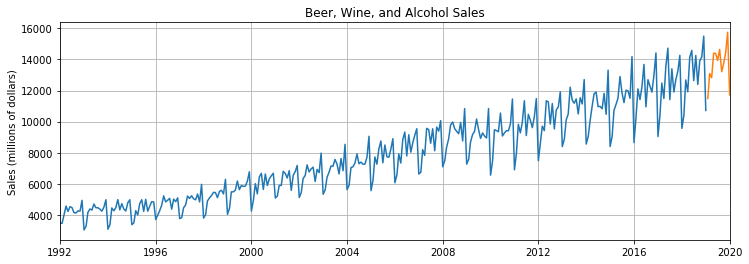

In [31]:
window_size = 12
future = 12
L = len(y)

preds = y_norm[-window_size:].tolist()

model.eval()
for i in range(future):  
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        # Reset the hidden parameters here!
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))  
        preds.append(model(seq).item())

# Inverse-normalize the prediction set
true_predictions = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

# PLOT THE RESULT
# Set a data range for the predicted data.
# Remember that the stop date has to be later than the last predicted value.
x = np.arange('2019-02-01', '2020-02-01', dtype='datetime64[M]').astype('datetime64[D]')

plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions[window_size:])
plt.show()

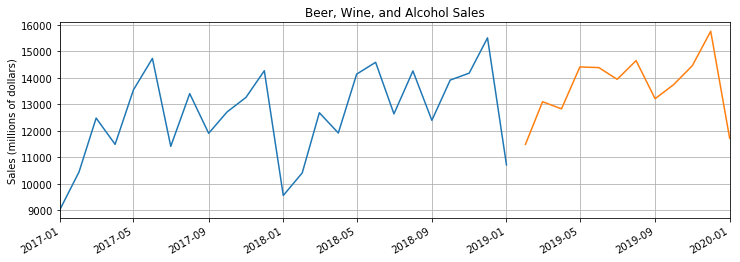

In [32]:
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions[window_size:])
plt.show()

## Great job!

<h3>BONUS:</h3>To save time in the future, we've written a function that will take in a time series training data set, and output a tensor of <tt>(seq, label)</tt> tuples.

In [34]:
# Load dependencies
from sklearn.preprocessing import MinMaxScaler

# Instantiate a scaler
"""
This has to be done outside the function definition so that
we can inverse_transform the prediction set later on.
"""
scaler = MinMaxScaler(feature_range=(-1, 1))

# Extract values from the source .csv file
df = pd.read_csv('../Data/TimeSeriesData/Alcohol_Sales.csv',index_col=0,parse_dates=True)
y = df['S4248SM144NCEN'].values.astype(float)

# Define a test size
test_size = 12

# Create the training set of values
train_set = y[:-test_size]

In [32]:
# DEFINE A FUNCTION:
def create_train_data(seq,ws=12):
    """Takes in a training sequence and window size (ws) of
       default size 12, returns a tensor of (seq/label) tuples"""
    seq_norm = scaler.fit_transform(seq.reshape(-1, 1))    
    seq_norm = torch.FloatTensor(seq_norm).view(-1)

    out = []
    L = len(seq_norm)
    for i in range(L-ws):
        window = seq_norm[i:i+ws]
        label = seq_norm[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [33]:
# Apply the function to train_set
train_data = create_train_data(train_set,12)
len(train_data)  # this should equal 313-12

301

In [34]:
train_data[0]

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901, -0.7933, -0.6743]), tensor([-1.]))

In [35]:
help(create_train_data)

Help on function create_train_data in module __main__:

create_train_data(seq, ws=12)
    Takes in a training sequence and window size (ws) of
    default size 12, returns a tensor of (seq/label) tuples

